# Bank Marketing Dataset – Data Processing & Feature Engineering

## Objective
This notebook performs all data-related steps required before model training:
- Data collection
- Data validation
- Data cleaning
- Exploratory Data Analysis (EDA)
- Feature engineering
- Feature selection
- Preparing model-ready data

Each step answers:
- **What is being done**
- **Why it is required**

This notebook outputs a clean, validated dataset for downstream modeling.


In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import statsmodels.api as sm


In [2]:
# Load Bank Marketing dataset from UCI
bank_marketing = fetch_ucirepo(id=222)

# Separate features and target
X = bank_marketing.data.features
y = bank_marketing.data.targets

# Combine into single DataFrame
df = pd.concat([X, y], axis=1)

# Rename target column
df.rename(columns={df.columns[-1]: 'y'}, inplace=True)


## Initial Data Understanding

We examine:
- Dataset shape
- Column data types
- Missing values
- Target distribution

This step helps identify data quality issues early.


In [3]:
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [4]:
df.shape


(45211, 17)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Data Cleaning Decisions

| Column     | Action | Reason |
|-----------|-------|--------|
| job       | Dropped | High noise and weak predictive contribution |
| duration  | Dropped | Data leakage (known only after call ends) |
| education | KNN imputation | Correlated with demographic features |
| contact   | New category | Missingness is informative |
| poutcome  | New category | Represents no previous campaign |


In [6]:
df.drop(columns=['job', 'duration'], inplace=True)


In [7]:
df['contact'] = df['contact'].fillna('not_recorded')
df['poutcome'] = df['poutcome'].fillna('no_previous_campaign')


## KNN Imputation for Education

Education is imputed using KNN because:
- It correlates with age and balance
- Missingness is not purely random
- KNN preserves local data structure

Categorical encoding is temporary and reversed after imputation.


In [8]:
edu_encoder = LabelEncoder()
df['education_encoded'] = edu_encoder.fit_transform(df['education'].astype(str))

knn_features = df[['age', 'balance', 'education_encoded']]

knn_imputer = KNNImputer(n_neighbors=5)
knn_imputed = knn_imputer.fit_transform(knn_features)

df['education_encoded'] = knn_imputed[:, 2].round().astype(int)
df['education'] = edu_encoder.inverse_transform(df['education_encoded'])

df.drop(columns=['education_encoded'], inplace=True)


## Target Variable Analysis

The target variable is binary:
- 1 → Customer subscribed
- 0 → Customer did not subscribe

Class imbalance must be evaluated to choose correct metrics.


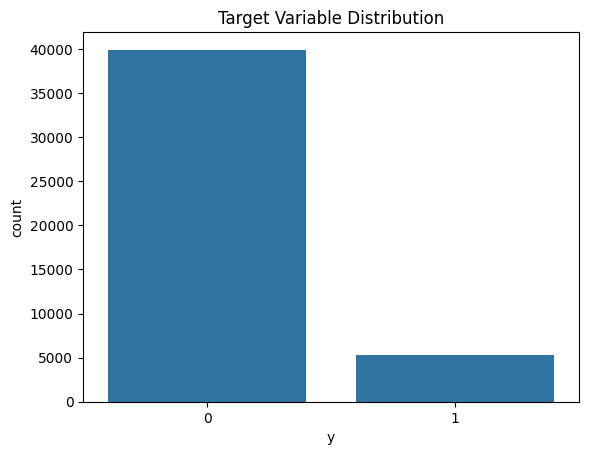

In [9]:
df['y'] = df['y'].map({'no': 0, 'yes': 1})

sns.countplot(x='y', data=df)
plt.title("Target Variable Distribution")
plt.show()


class is imbalance its more towards no then yes

Univariate analysis of numerical features is performed to:
- Detect skewness
- Identify potential outliers
- Understand feature ranges


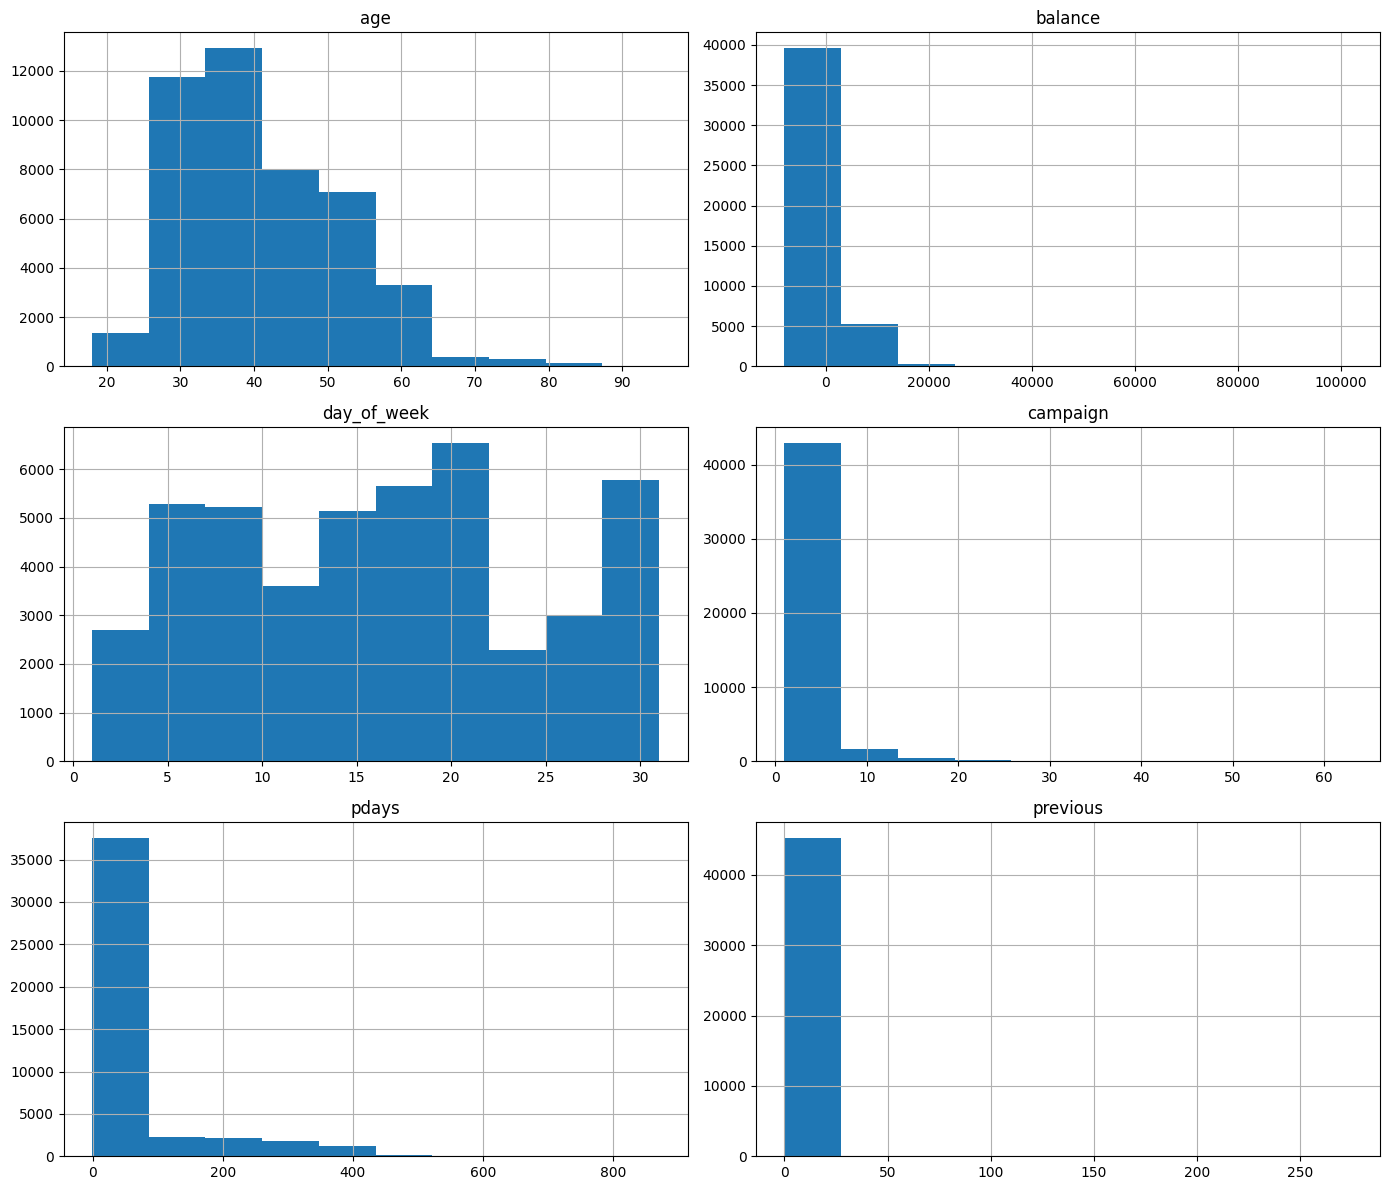

In [10]:
num_cols = df.select_dtypes(include=['int64', 'float64']).drop('y', axis=1)

num_cols.hist(figsize=(14, 12))
plt.tight_layout()
plt.show()


## Outlier Detection

Outliers are identified using boxplots and IQR analysis.
Outliers are **not removed at this stage**, as tree-based models can handle them
and removal may lead to information loss.


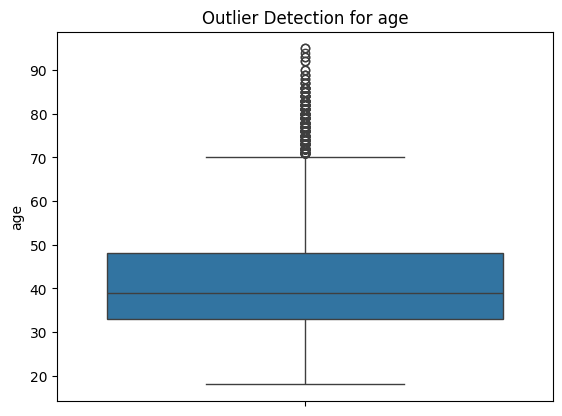

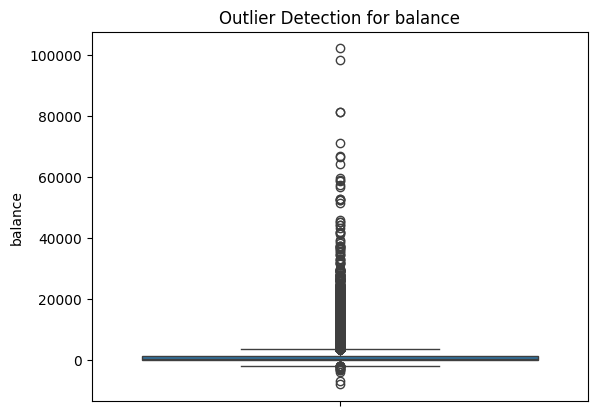

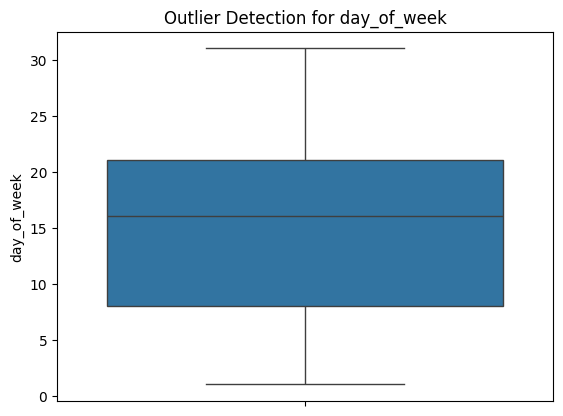

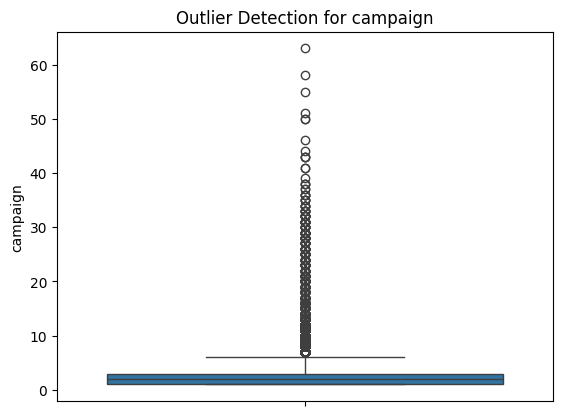

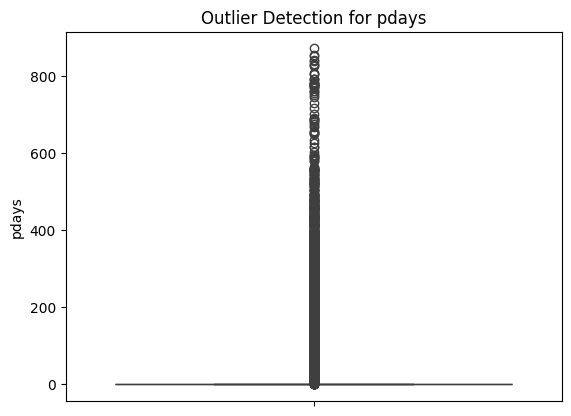

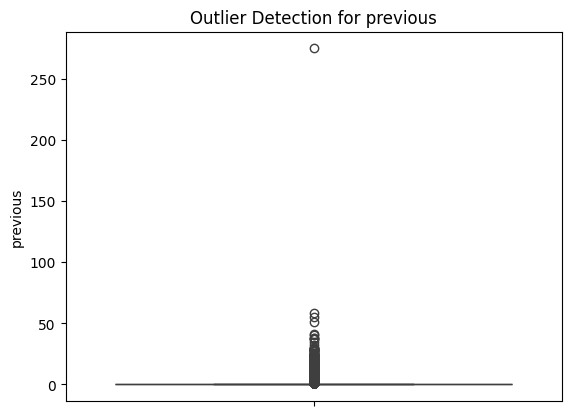

In [11]:
for col in num_cols.columns:
    sns.boxplot(y=df[col])
    plt.title(f"Outlier Detection for {col}")
    plt.show()


## Numerical Features vs Target

Boxplots reveal how numerical variables differ across target classes.


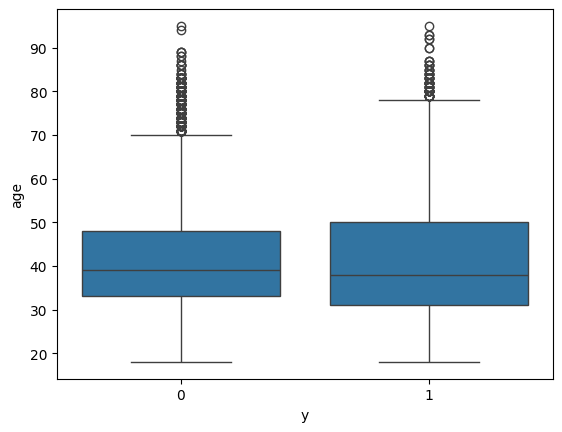

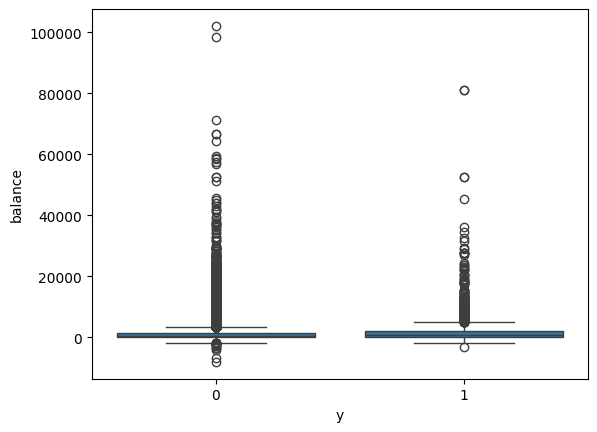

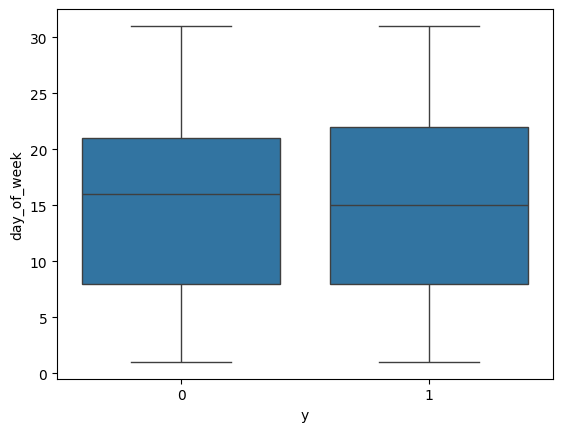

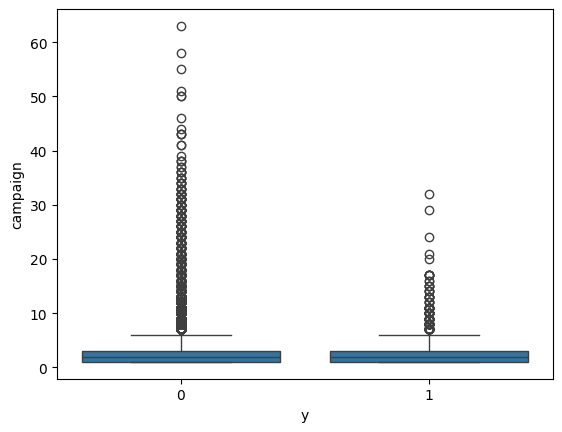

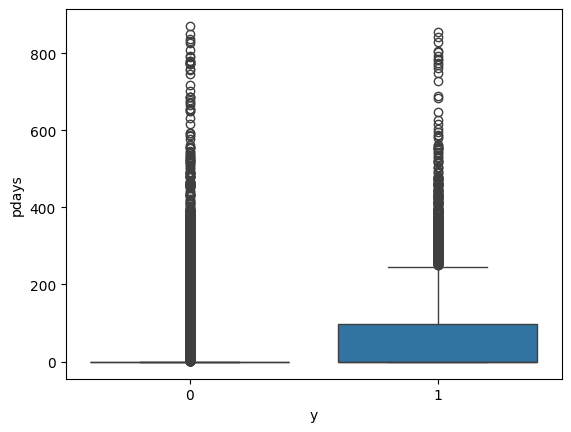

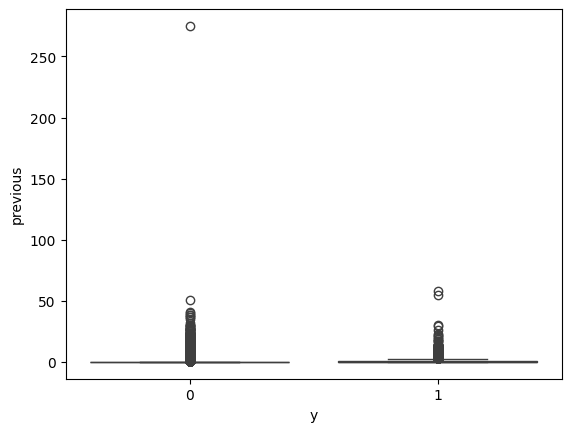

In [12]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).drop('y', axis=1).columns

for col in numerical_cols:
    sns.boxplot(x='y', y=col, data=df)
    plt.show()


This analysis evaluates how categorical variables influence subscription behavior.


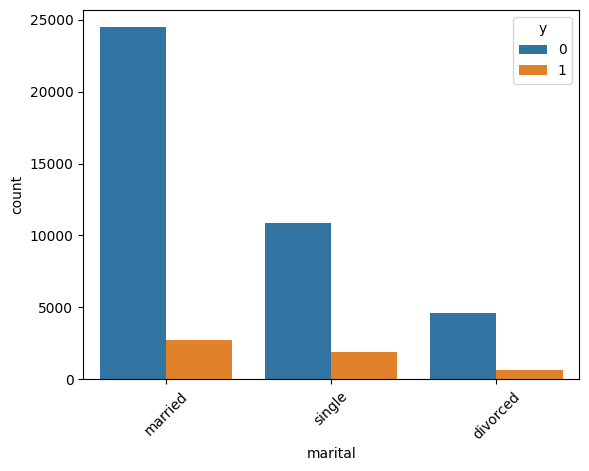

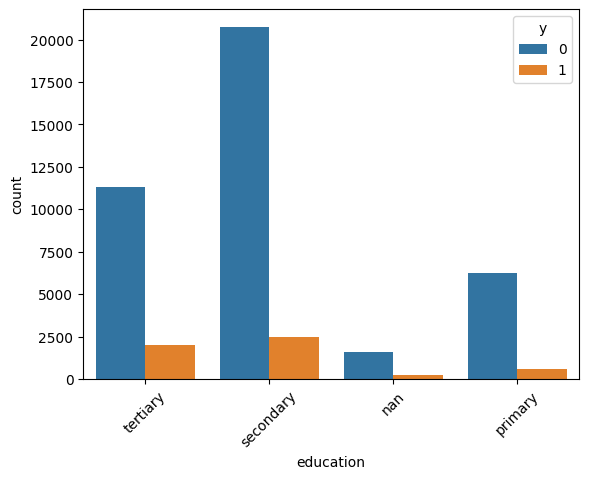

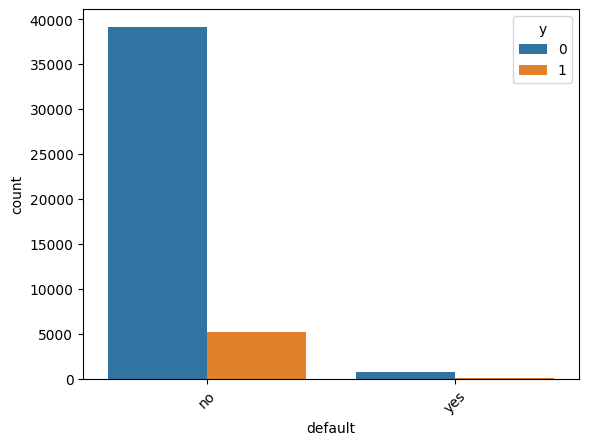

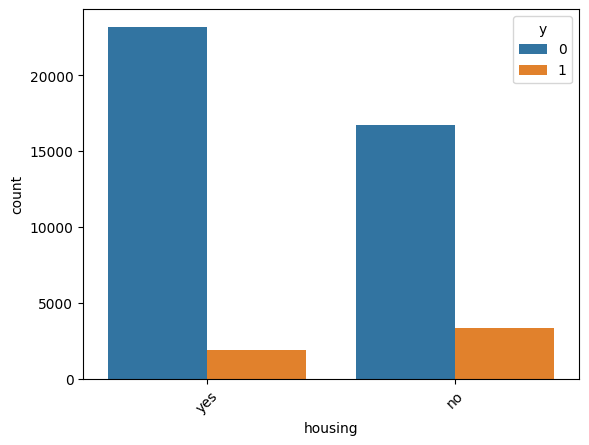

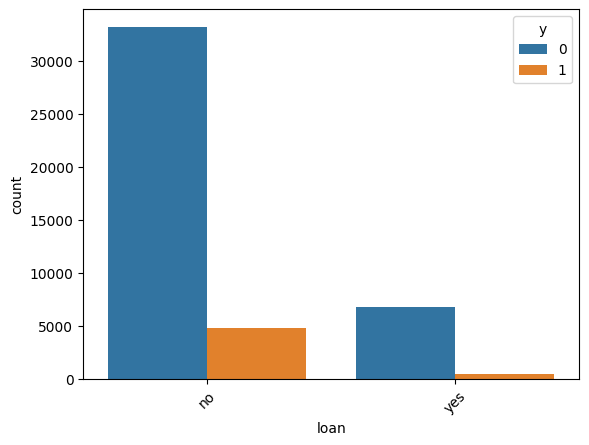

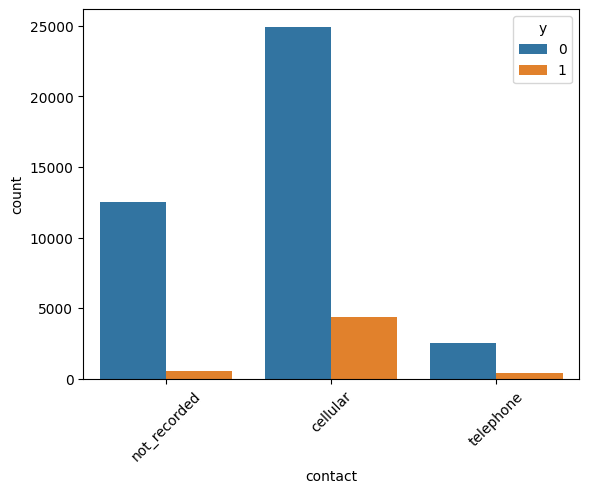

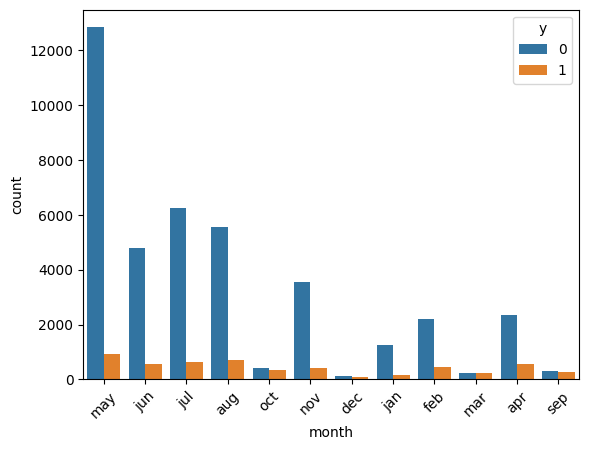

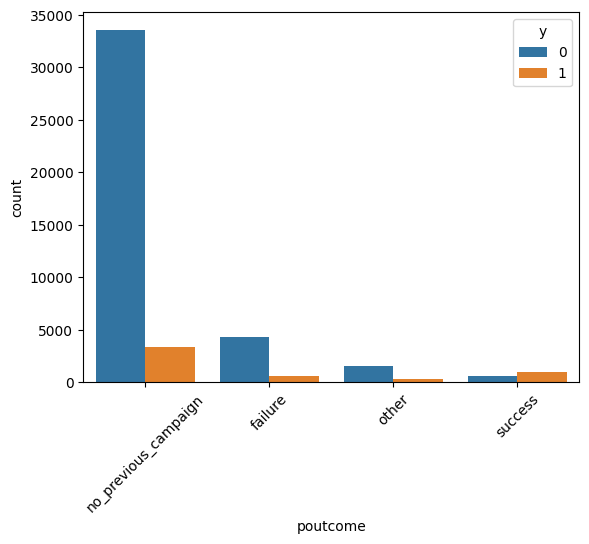

In [13]:
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    sns.countplot(x=col, hue='y', data=df)
    plt.xticks(rotation=45)
    plt.show()


Boxplots compare numerical feature distributions across target classes.


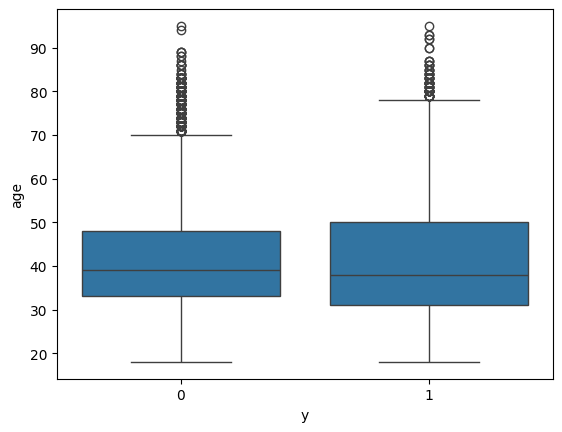

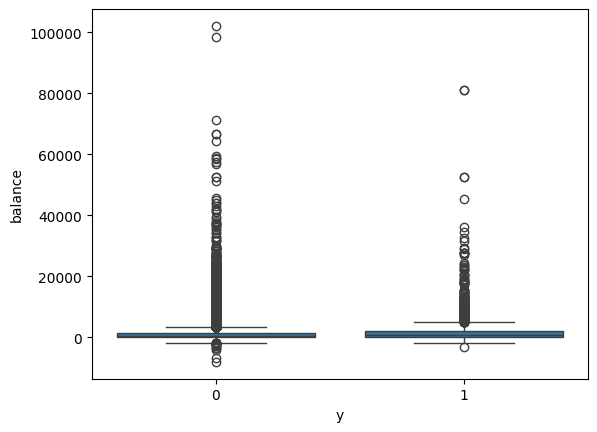

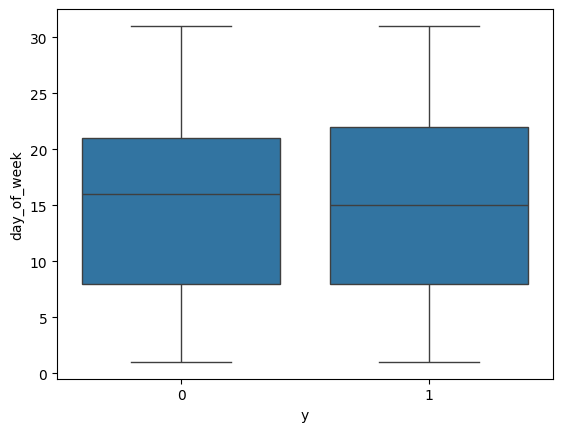

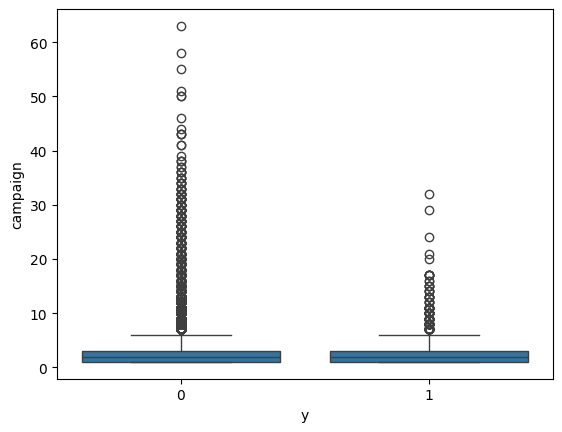

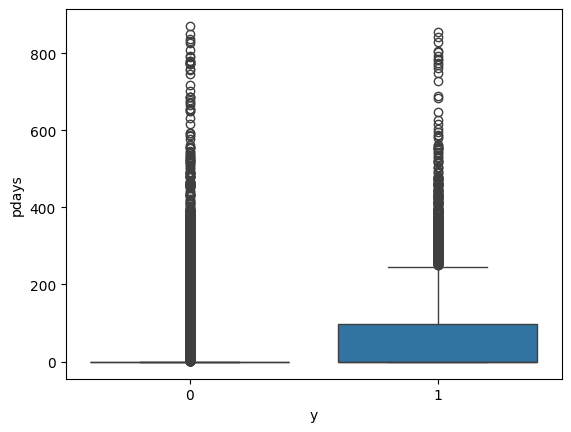

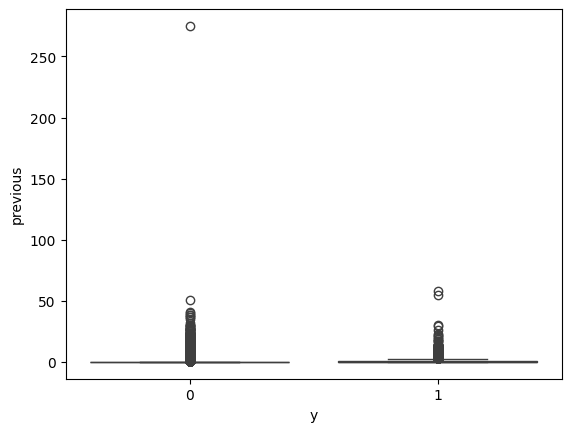

In [14]:
for col in num_cols.columns:
    sns.boxplot(x='y', y=col, data=df)
    plt.show()


Correlation analysis is used to understand linear relationships
and detect multicollinearity. No features are removed based on correlation alone.


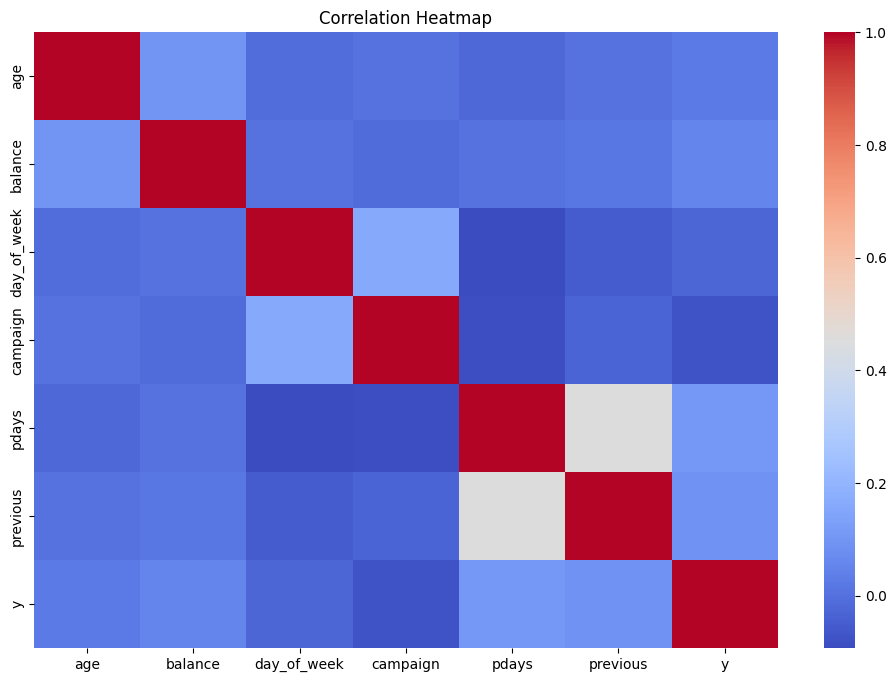

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()


Pairwise plots help visualize interactions between numerical features
and their relationship with the target.


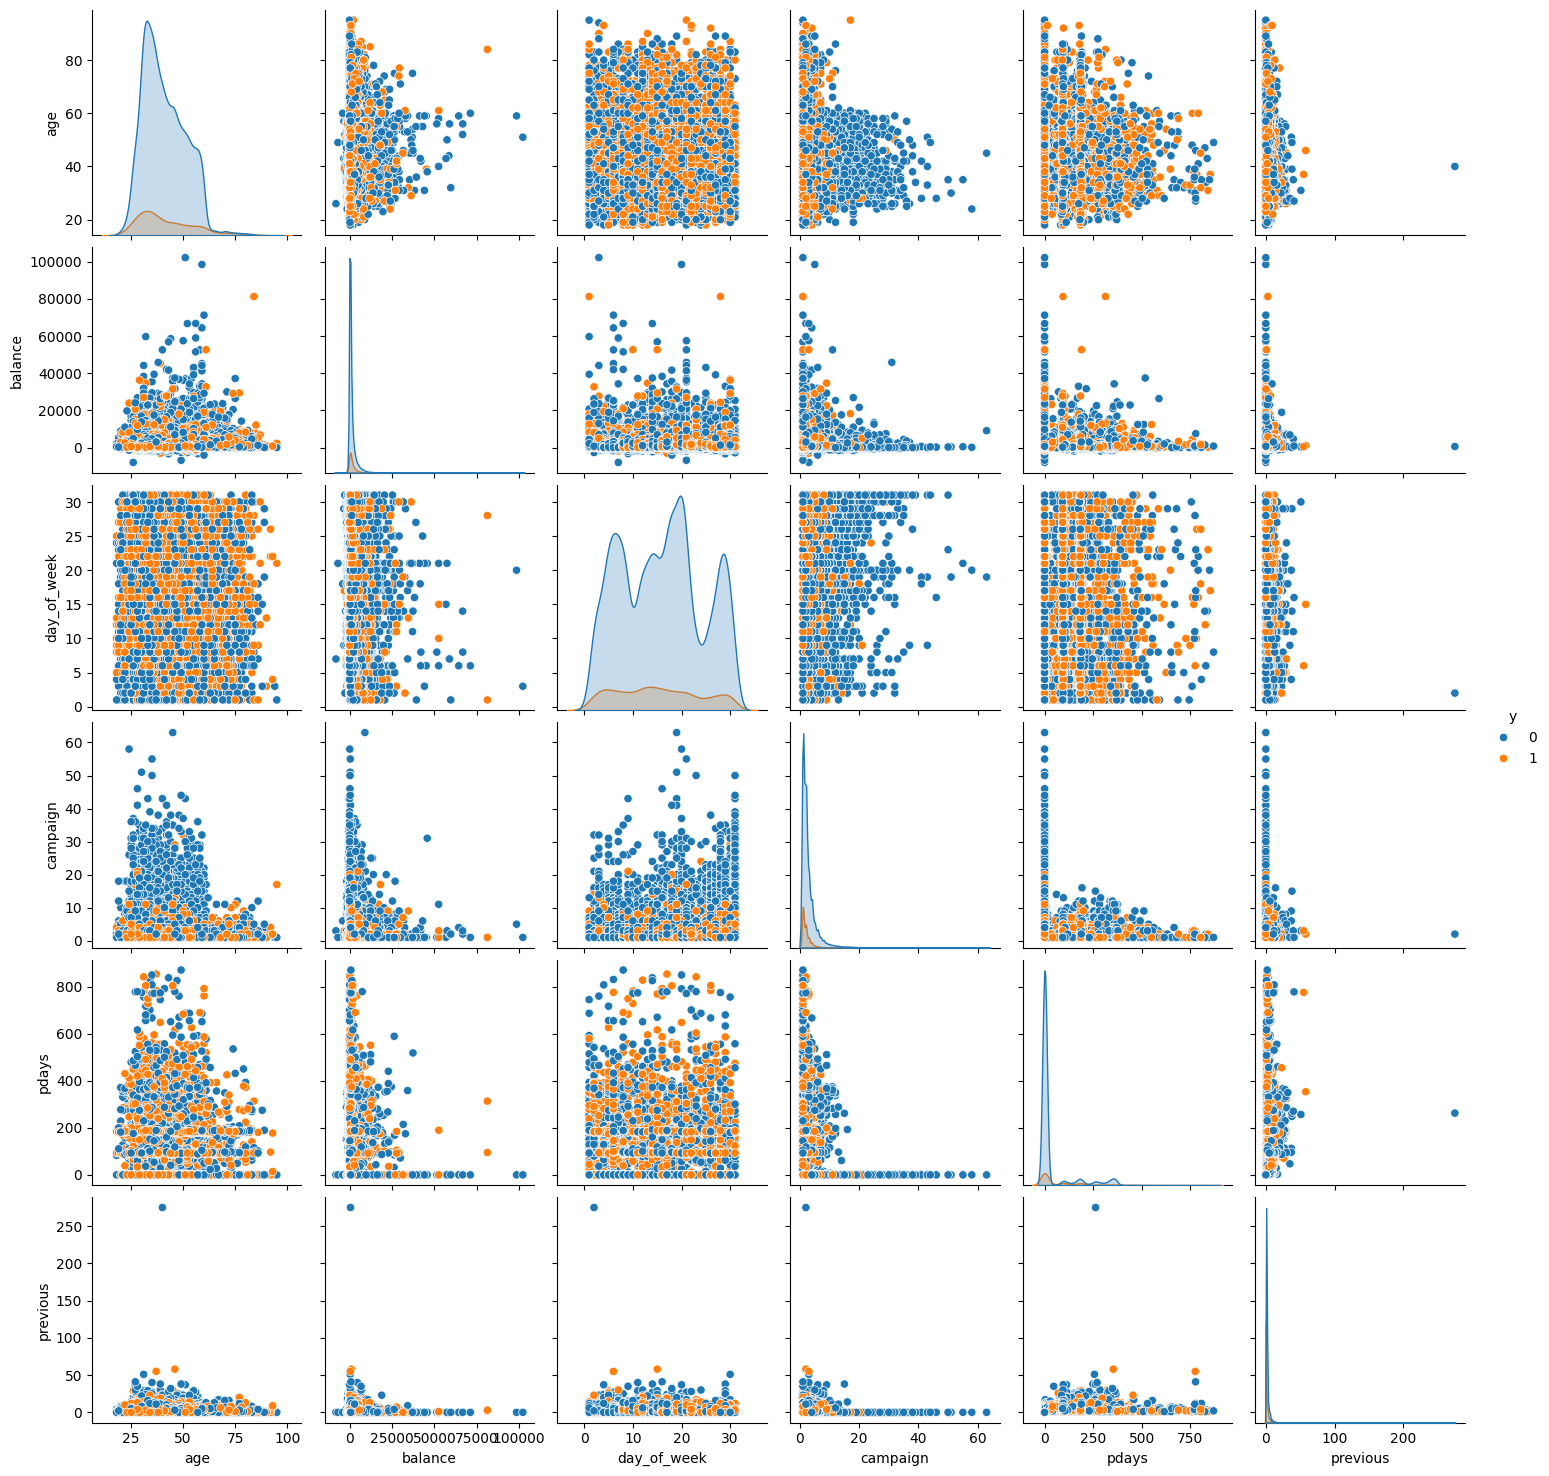

In [16]:
sns.pairplot(df[num_cols.columns.tolist() + ['y']], hue='y')
plt.show()
